**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

In [1]:
# !pip install SimPEG

In [4]:
import numpy as np
import scipy.sparse as sp
from SimPEG import Mesh, Utils, Solver  
from scipy.constants import mu_0, epsilon_0
import matplotlib.pyplot as plt

%matplotlib inline

# Numerical simulation of the 1D Magnetotelluric (MT) problem

##  Purpose

With [SimPEG's](http://simpeg.xyz) mesh class, we discretize Maxwell's equations for a 1D magnetotelluric problem. We then solve for both electric and magnetic fields, and evaluate data at a receing location. There are some milestones to be accomplished:

- Introduce differential operators and the terminology used in the SimPEG mesh class

- Set up boundary conditions

- Set up an linear system $\mathbf{A}\mathbf{u} = \mathbf{rhs}$, compute the fields, $\mathbf{u}$

- Evaluate the data at a receiver location: apparent resistivity and phase

- Recognize extensibility of this example to higher dimensions: 2D and 3D

## Physics: Maxwell's equations

The governing equations for electromagnetic problems are Maxwell's equations. Here, we show them in the frequency domain. For more background on Maxwell's equations, we recommend http://em.geosci.xyz and [Ward & Hohmann, 1988](http://library.seg.org/doi/abs/10.1190/1.9781560802631.ch4).

$$\nabla \times \mathbf{E} + \imath\omega \mu \mathbf{H} = 0 $$

$$\nabla \times \mathbf{H} + (\sigma + \imath \omega \epsilon) \mathbf{E} = 0$$

where

- $\mathbf{E}$ is the electric field (V/m)
- $\mathbf{H}$ is the magnetic field (A/m)
- $\omega = 2\pi f$ is the angular frequency
- $\mu$ is the magnetic permeability, often taken to be that of free spase ($\mu_0 = 4\pi\times 10^{-7}$ H/m)
- $\sigma$ is the electrical conductivity (S/m). 
- $\epsilon$ is the dielectric permittivity, often taken to be that of free space ($\epsilon = 8.85 \times 10^{-12}$ F/m)

For convienence, we will make the substitution: $\hat{\sigma} = \sigma + \imath \omega \epsilon$ and write Maxwell's equations as

$$\nabla \times \mathbf{E} + \imath\omega \mu \mathbf{H} = 0$$

$$\nabla \times \mathbf{H} + \hat{\sigma} \mathbf{E} = 0$$

The first equation is [Faraday's Law](http://em.geosci.xyz/content/maxwell1_fundamentals/formative_laws/faraday.html), and the second is [Ampere's Law](http://em.geosci.xyz/content/maxwell1_fundamentals/formative_laws/ampere_maxwell.html)

For the Magnetotelluric problem, we are interested in examining Maxwell's equations for a plane wave source. We consider a vertically propagating plane wave. For a 1D earth model, the fields and fluxes are defined by horizontal, orthogonal electric and magnetic fields, so we take

$$\mathbf{E} = E_x\mathbf{\hat{x}}$$
$$\mathbf{H} = H_y\mathbf{\hat{y}}$$

<img src="http://em.geosci.xyz/_images/planewavedown1.png" alt="plane_wave" href="http://em.geosci.xyz/content/maxwell1_fundamentals/plane_waves_in_homogeneous_media/index.html" width=300px>

The coordinate system we use is right-handed, and $z$ is positive up. 

In this case, our governing equations simplify to scalar equations

$$ \frac{\partial E_x}{\partial z}  + \imath \omega \mu H_y = 0$$

$$-\frac{\partial H_y}{\partial z} +  \hat{\sigma} E_x = 0$$

with the boundary conditions:

$$E_x (z=0) = 1$$

$$E_x (z=-\infty) = 0$$

To solve the forward problem, the 
- **knowns** are: $\omega$, $\mu$, $\hat{\sigma}$, boundary conditions
- **unknowns** are: $E_x$, $H_y$

## Discretiation, the Short version. 

**TL;DR.** Here is the answer. 
If you want to see the full derivation, checkout <a href="##Discretization,-the-Gory-Details.">The Gory Details</a> 


We define physical properties at cell centers, and stagger the electric and magnetic fields

- $\sigma$, $\mu$, $\epsilon$ : cell centers
- $E_x$: cell centers
- $H_y$: faces

<img src="./images/1DMT_discretize.png" width=200px> 

and use a finite difference approach to define the operators, this gives us the discrete system of equations

$$
\underbrace{
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\hat{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix}
}_{\mathbf{A}}
\underbrace{
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{u}}
=
\underbrace{
    \begin{bmatrix}
       - \mathbf{B}\mathbf{e_x}^{BC} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{rhs}}
$$

with 

- $\mathbf{e_x}$: Discrete $E_x$, on cell centers $[\text{nC} \times 1]$

- $\mathbf{h_y}$: Dicrete $H_x$, on cell faces $[(\text{nC}+1) \times 1]$

- $ \mathbf{Grad}$: Discrete gradient operator $[\text{nC} \times (\text{nC}+1)]$

- $ \mathbf{Div}$: Discrete divergence operator $[(\text{nC}+1) \times \text{nC}]$

- $\mathbf{M}^{f}_{\boldsymbol{\mu}} = \mathbf{diag}(\mathbf{Av^{cc2f}}  \boldsymbol{\mu})$ $[(\text{nC}+1) \times (\text{nC}+1)]$

- $\mathbf{M}^{cc}_{\boldsymbol{\hat{\sigma}}} = \mathbf{diag}(\boldsymbol{\hat{\sigma}})$ $[\text{nC} \times \text{nC}]$

- $\mathbf{B} \mathbf{e_x}^{BC}$ handles the boundary conditions

## Designing a mesh

When designing a mesh, we need to ensure that we can capture the physics (what should the thickness of the finest cells be?) and make sure that the boundary is far enough away so that the fields have decayed (how far do we need to go to approximate $\infty$??). To address these, we look at the [skin depth equation](http://em.geosci.xyz/content/maxwell1_fundamentals/plane_waves_in_homogeneous_media/frequency/analytic_solution.html#attenuation-and-skin-depth), which tells us over what distance we expect electromagnetic fields to have decayed by a factor of $1/e$ in a conductive medium:

$$
\delta = \frac{500}{\sqrt{\sigma f}}
$$

- The finest cells capture the behaviour of the highest frequency near the surface
- The mesh needs to extend far enough so that the fields at the lowest frequency have sufficiently decayed

Lets start by considering:
- a half-space with conductivity $\sigma = 10^{-2}$ S/m 
- a maximum frequency of 1000 Hz
- a minimum frequency of 0.01 Hz

In [8]:
sigma_halfspace = 1e-2
fmax, fmin = 1e3, 1e-2

In [9]:
def skin_depth(sigma, f):
    return 500./np.sqrt(sigma*f)

In [10]:
skin_depth_min = skin_depth(sigma_halfspace, fmax)
skin_depth_max = skin_depth(sigma_halfspace, fmin)

print("The minimum skin depth is {:2.1f} m".format(skin_depth_min))
print("The maximum skin depth is {:2.1f} m".format(skin_depth_max))

The minimum skin depth is 158.1 m
The maximum skin depth is 50000.0 m


To ensure that we are capturing the physics and have a sufficiently far boundary, we will choose
- a minimum cell size of $\delta_{\text{min}}/4$
- a padding distance that extends to $2 \delta_{\text{max}}$

In [11]:
print("The smallest cell size should be {:2.1f} m".format(skin_depth_min / 4.))
print("The mesh should extend {:1.1e} m".format(skin_depth_max * 2.))

The smallest cell size should be 39.5 m
The mesh should extend 1.0e+05 m


### Set up a mesh

Here, we use the [SimPEG Mesh class](http://docs.simpeg.xyz) to set up the mesh, differential operators, and handy properties and methods that handle counting and plotting. 

The mesh extends 1.2e+05m, is that far enough?


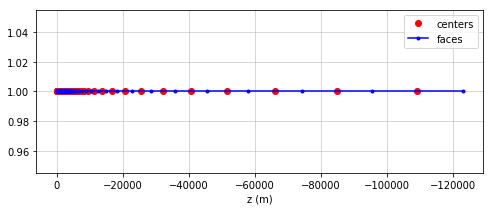

In [13]:
cs = 39.  # core cell size
npad = 25  # number of padding cells
ncz = 100   # number of core cells

# define a tensor mesh
hz = [(cs, npad, -1.3), (cs, ncz)] 
mesh = Mesh.TensorMesh([hz], x0='N')  # put the origin at the surface 

# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(8, 3))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')
ax.grid(which="both", linewidth=0.5)

print(
    "The mesh extends {:1.1e}m, is that far enough?".format(mesh.hx.sum())
)

## Assemble the discrete system of equations

#### Model parameters

We start with a half space that has physical properties
- $\sigma = 10^{-2}$ S/m
- $\mu = \mu_0$
- $\epsilon = \epsilon_0$

and define these on the mesh

In [15]:
sigma = np.ones(mesh.nC)*sigma_halfspace # conductivity values for all cells
mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells

print(
    "There are {:1.0f} cell centers. \n"
    " sigma   is {:1.0f} elements long, all cells have a value of {:1.2e} S/m \n"
    " mu      is {:1.0f} elements long, all cells have a value of {:1.2e} H/m \n"
    " epsilon is {:1.0f} elements long, all cells have a value of {:1.2e} F/m \n".format(
        mesh.nC, 
        len(sigma), sigma_halfspace,
        len(mu), mu_0,
        len(epsilon), epsilon_0
    )
)

There are 125 cell centers. 
 sigma   is 125 elements long, all cells have a value of 1.00e-02 S/m 
 mu      is 125 elements long, all cells have a value of 1.26e-06 H/m 
 epsilon is 125 elements long, all cells have a value of 8.85e-12 F/m 



We will pick a single frequency to work with for now
- f = 1 Hz

In [16]:
frequency = 1. # Frequency (Hz)
omega = 2*np.pi*frequency # Angular frequency (rad/s)

Here, we will adopt the quasistatic assumption and ignore displacement current $(i \epsilon \omega)$. To explore the impacts of this assumption, uncomment the next second line

In [17]:
sigmahat = sigma  # quasi-static assumption
# sigmahat = sigma + 1j*epsilon*omega  # includes displacement current

The system we want to solve is
$$
\underbrace{
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\hat{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix}
}_{\mathbf{A}}
\underbrace{
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{u}}
=
\underbrace{
    \begin{bmatrix}
       - \mathbf{B}\mathbf{e_x}^{BC} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{rhs}}
$$

so we need to construct each of the operators. For details, see: <a href="#Discretization,-the-Gory-Details.">The Gory Details</a> 

We start by laying our the piece and will then assemble the full matrix system. 

In [19]:
# Grad 
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
Grad = mesh.cellGrad # Gradient matrix

# MfMu
Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

# Mccsigma
Msighat = Utils.sdiag(sigmahat) 

# Div
Div = mesh.faceDiv # Divergence matrix

# Right Hand Side
B = mesh.cellGradBC  # a matrix for boundary conditions
Exbc = np.r_[0., 1.] # boundary values for Ex

In [20]:
# Assemble the matrix

# A-matrix
A = sp.vstack([
    sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
    sp.hstack((Msighat, Div)) # Bottom row of A matrix
])

# Right-hand side
rhs = np.r_[
    -B*Exbc, 
    np.zeros(mesh.nC)
] 

Now that we have all of the pieces, we can go ahead and solve the MT system

In [22]:
%%time
Ainv = Solver(A) # Factorize A matrix
sol = Ainv*rhs   # Solve A^-1 rhs = sol
Ex = sol[:mesh.nC] # Extract Ex from solution vector u
Hy = sol[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u

CPU times: user 1.4 ms, sys: 777 µs, total: 2.17 ms
Wall time: 1.63 ms


## Impedance, Apparent Resistivity, and Phase

MT data are natural source data, meaning that the source is free! but we don't know its amplitude. To account for this, the data we examine are typically transfer functions that involve ratios of the electric and magnetic fields. For the 1D problem, the Impedance is simply given by

$$
Z_{xy} = - \frac{E_x}{H_y}
$$

(The negative is because we have defined a coordinate system such that z is positive up) 

$Z_{xy}$ is a complex number, so we can look at real and imaginary components or amplitude and phase. 


In [23]:
Zxy = - 1./Hy[-1] # Impedance at the surface

print("Impedance: {:1.1e} + {:1.1e}i".format(Zxy.real, Zxy.imag))
print("or in terms of Amplidude: {:1.1e} and phase: {:1.1f} degrees".format(
    np.absolute(Zxy), np.rad2deg(np.arctan(Zxy.imag / Zxy.real)))
)

Impedance: 2.0e-02 + 2.0e-02i
or in terms of Amplidude: 2.8e-02 and phase: 44.9 degrees


Often is useful to translate the impedance to an apparent resistivity ($\rho_a$) and phase. 

$$
\rho_a = \frac{1}{\mu_0\omega} \big|Z_{xy}\big|^2
$$

$$
\phi = \tan^{-1}\left(\frac{\mathcal{Im}(Z_{xy})}{\mathcal{Re}(Z_{xy})}\right)
$$

For a  half-space, we expect the apparent resistivity to equal the true resistivity, and the phase to be $45^\circ$

In [24]:
app_res = abs(Zxy)**2 / (mu_0*omega)
app_phase = np.rad2deg(np.arctan(Zxy.imag / Zxy.real))

print("Apparent Resistivity: {:1.1f}, Phase: {:1.1f}".format(app_res, app_phase))

Apparent Resistivity: 100.0, Phase: 44.9


In [25]:
print(
    "Note that the apparent resistivity, {:1.1f} "
    "is the same as the true half-space {:1.1f}".format(
        app_res,
        1./sigma_halfspace  
    )
)

Note that the apparent resistivity, 100.0 is the same as the true half-space 100.0


## Put it all together

Here, we define a function that performs an MT simulation so that we can readily compute the Magnetotelluric response at multiple frequencies and for a variety of models. We write this function to the file MTsimulation.py so that we can import it and use it in later notebooks. Uncomment the first three lines to write out the file again. 

In [26]:
# %%writefile MTforward.py
# import numpy as np
# import scipy.sparse as sp
# from scipy.constants import mu_0
# from SimPEG import Utils, Solver


def simulateMT(mesh, sigma, frequency, rtype="app_res"):
    """
       Compute apparent resistivity and phase at each frequency. 
       Return apparent resistivity and phase for rtype="app_res",
       or impedance for rtype="impedance" 
    """
    
    # Angular frequency (rad/s)
    def omega(freq):
        return 2*np.pi*freq
    
    # make sure we are working with numpy arrays
    if type(frequency) is float:
        frequency = np.r_[frequency]  # make it a list to loop over later if it is just a scalar
    elif type(frequency) is list: 
        frequency = np.array(frequency)
    
    # Frequency independent pieces of the A matrix
    # Grad 
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix

    # MfMu
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

    # Mccsigma
    sigmahat = sigma  # quasi-static assumption
    Msighat = Utils.sdiag(sigmahat) 

    # Div
    Div = mesh.faceDiv # Divergence matrix

    # Right Hand Side
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex
    
    # Right-hand side
    rhs = np.r_[
        -B*Exbc, 
        np.zeros(mesh.nC)
    ] 
    
    # loop over frequencies 
    Zxy = []
    for freq in frequency: 

        # A-matrix
        A = sp.vstack([
            sp.hstack([Grad, 1j*omega(freq)*Mmu]), # Top row of A matrix
            sp.hstack((Msighat, Div)) # Bottom row of A matrix
        ])
    
        Ainv = Solver(A) # Factorize A matrix
        sol = Ainv*rhs   # Solve A^-1 rhs = sol
        Ex = sol[:mesh.nC] # Extract Ex from solution vector u
        Hy = sol[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u

        Zxy.append(- 1./Hy[-1]) # Impedance at the surface
    
    # turn it into an array
    Zxy = np.array(Zxy)

    # return impedance or apparent resistivity and phase 
    if rtype.lower() == "impedance":
        return Zxy

    elif rtype.lower() == "app_res":
        app_res = abs(Zxy)**2 / (mu_0*omega(frequency))
        app_phase = np.rad2deg(np.arctan(Zxy.imag / Zxy.real))
        return app_res, app_phase
    
    else:
        raise Exception, "rtype must be 'impedance' or 'app_res', not {}".format(rtype.lower())

In [27]:
%%time 

# Run the simulation over 25 frequencies from 1e-3 Hz to 100 Hz
frequencies = np.logspace(-2, 3, 25)

# for freq in frequencies:
app_res, phase = simulateMT(mesh, sigma, frequencies)

CPU times: user 62.9 ms, sys: 2.76 ms, total: 65.6 ms
Wall time: 64.4 ms


For a half-space, the apparent resistivity should equal the true resistivity and the phase should be $45^\circ$. How did we do??

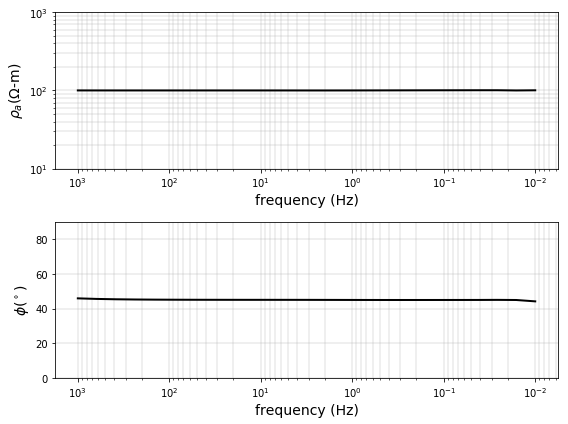

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(8, 3*2))

# plot apparent resistivity
ax[0].loglog(frequencies, app_res, 'k', lw=2)
ax[0].set_ylim(1./sigma_halfspace*np.r_[0.1, 10])
ax[0].set_ylabel("$ \\rho_a (\Omega$-m)", fontsize=14)

# plot phase
ax[1].semilogx(frequencies, phase, 'k', lw=2)
ax[1].set_ylim(np.r_[0., 90.])
ax[1].grid(which="both", linewidth=0.4)

ax[1].set_xlabel("frequency (Hz)", fontsize=14)
ax[1].set_ylabel("$\phi (^\circ)$", fontsize=14)

for a in ax:
    a.invert_xaxis()  # highest frequencies see the near surface, lower frequencies see deeper
    a.set_xlabel("frequency (Hz)", fontsize=14)
    a.grid(which="both", linewidth=0.4)


plt.tight_layout()

# Discretization, the Gory Details. 

If you want to skip this section, we won't judge! 

To numerically solve Maxwell's equations, we need to first discretize them so they are represented on a mesh. We will take a finite difference approach for this example.

Since we are solving for a 1D model, we will use a 1D mesh and leverage the Mesh class in SimPEG to build the operators (see http://docs.simpeg.xyz for docs). 

We show a very small mesh in the derivation so that it is meaningful to print out the matrices. When we go to solve, we will use a larger mesh.

In [20]:
cell_size = 1. # width of the cell in meters
ncells = 4  # number of cells that make up our domain

# define a Tensor Mesh
dz = [(cell_size, ncells)]
mesh = Mesh.TensorMesh([dz], x0='N')

print(
    "This mesh has {nC} cells and {nF} faces. "
    "Each cell is {h}m wide".format(
        nC=mesh.nC, nF=mesh.nF, h=mesh.hx.min()  # it is hx because SimPEG treats dimensions in the order (x, y, z), so if the mesh is 1D, we work with the first component
    )
)

This mesh has 4 cells and 5 faces. Each cell is 1.0m wide


There are two places where we can discretize variables on a 1D mesh for the electromagnetic problem: cell centers and cell faces. 

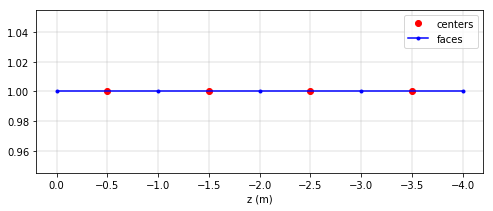

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.invert_xaxis()  # put the surface of the earth on the left. 
ax.set_xlabel('z (m)')
ax.grid(which="both", linewidth=0.4)
plt.legend(("centers", "faces"))

To count, we will use 
$$
i = 0, 1, 2, ..., N
$$
to denote cell centers, so faces are at $i \pm 1/2$.

To discretize our system of equations, we put the physical properties, $\sigma$, $\mu$, $\epsilon$ at cell centers and stagger the electric and magnetic fields so that $E_x$ is on cell centers and $H_y$ is at cell faces.

Our physical properties are described by the discrete vectors

$$
\boldsymbol{\sigma} = [\sigma_0, \sigma_1, \sigma_2, ..., \sigma_N]^\top
$$
$$
\boldsymbol{\mu} = [\mu_0, \mu_1, \mu_2, ..., \mu_N]^\top
$$
$$
\boldsymbol{\epsilon} = [\epsilon_0, \epsilon_1, \epsilon_2, ..., \epsilon_N]^\top
$$

and 
$$
\boldsymbol{\hat{\sigma}} = \boldsymbol{\sigma} + \imath \omega \boldsymbol{\epsilon}
$$
 
is also defined at cell centers. 

Our fields are described by the discrete vectors
$$
\mathbf{e_x} = [e_0, e_1, e_2, ..., e_N]^\top
$$

$$
\mathbf{h_y} = [h_{-1/2}, h_{1/2}, h_{1+1/2}, h_{2+1/2}, ..., h_{N+1/2}]^\top
$$

### Discretizing Ampere's law

Lets start by exmining Ampere's law (the second equation), 

$$-\frac{\partial H_y}{\partial z} +  \hat{\sigma} E_x = 0$$

To approximate the derivative of $H_y$ (which is defined on faces) with respect to $z$, we use centered differences, so 

$$
\frac{\partial H_y}{\partial z} \bigg\rvert_i \simeq \frac{h_{i+1/2} - h_{i-1/2}}{\Delta z_i}
$$

where $\Delta z_i$ is the width of the cell, and the approximation of the derivative lands on the cell center. We repeat this operation for each cell in our mesh. You could do this in a for loop, but it is often benificial to work with the matrix form, so we will do that here. 

The differential operator matrix that takes the derivative of a variable defined on faces is the face divergence operator.

$$
\frac{\partial H_y}{\partial z} \simeq \mathbf{Div} ~\mathbf{h_y}
$$

In [22]:
Div = mesh.faceDiv
print(Div.todense())  # operators are stored as sparse matrices in SimPEG

[[-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


Since the physical properties $\boldsymbol{\hat{\sigma}}$ is defined at cell centers which is in the same location as $E_x$, we can simply multiply them. In matrix form, we use a diagonal matrix, 

$$\mathbf{M^{cc}_{\boldsymbol{\hat{\sigma}}}} = \mathbf{diag}(\boldsymbol{\hat{\sigma}})$$ 

so the product is given by

$$
\hat{\sigma} E_x \simeq \mathbf{M^{cc}_{\boldsymbol{\hat{\sigma}}}} ~\mathbf{e_x}
$$

in the example that follows, we will assume that $\sigma \gg \imath \omega \epsilon$, so $\hat{\sigma} \simeq \sigma$. In the more general implementation later on in the tutorial, we will use the full definition of $\hat{\sigma}$ 

In [23]:
sigma = 1e-1 * np.ones(mesh.nC)
Mcc_sigma = Utils.sdiag(sigma)
print(Mcc_sigma.todense())

[[ 0.1  0.   0.   0. ]
 [ 0.   0.1  0.   0. ]
 [ 0.   0.   0.1  0. ]
 [ 0.   0.   0.   0.1]]


So we have taken

$$-\frac{\partial H_y}{\partial z} +  \hat{\sigma} E_x = 0$$

and discretized to 

$$
- \mathbf{Div} ~ \mathbf{h_y} + \mathbf{M^{cc}_{\boldsymbol{\hat{\sigma}}}} ~ \mathbf{e_x} = \mathbf{0}
$$

### Discretizing Faraday's Law

Next, we examine Faraday's law:

$$
\frac{\partial E_x}{\partial z}  + \imath \omega \mu H_y = 0
$$

Over one cell, the discrete approximation of the derivative of $E_x$ with respect to $z$ is

$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{i+1/2} = \frac{e_{i+1} - e_{i}}{\Delta z_{i+1/2}}
$$

where $\Delta z_{1+1/2}$ is the distance (m) from the cell center $z_{i}$ to $z_{i+1}$. Notice here that we are going from cell centers to cell faces. So in this case we need to handle the boundary conditions, what do we do at 
the top and the bottom:
$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{-1/2}, \quad
\frac{\partial E_x}{\partial z}\bigg\rvert_{nC+1/2} 
$$

we somehow need to define "ghost points" $e_{-1}$ and $e_{N+1}$ so that we can solve  

$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{-1/2} = \frac{e_{0} - e_{-1}}{\Delta z_{-1/2}}
$$

and

$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{N+1/2} = \frac{e_{N+1} - e_{N}}{\Delta z_{N+1/2}}
$$

#### Boundary Conditions

Lets start with the bottom boundary - we know that MT fields and fluxes are diffusive and decay as they travel through conductive media, so if our boundary is sufficiently far away

$$E_x (z=-\infty) = 0$$

Clearly we can't discretize to infinity... but we know approximately how quickly the fields decay, this is captured by the skin depth

$$
\delta \simeq \frac{500}{\sqrt{\sigma f}}
$$

So as long as we define our mesh such that we are a few skin depths from the surface, then we can safely assume that the fields will have decayed to zero (dirichlet boundary condition). In our discrete world, this means that we want to enforce

$$
E_x \big|_{nC+{1/2}} = 0
$$

The elements of $e$ are defined on cell centers and our boundary is a face, so we choose our ghost point $e_N$ such that when we average across the boundary, the average is 0, eg

$$
\frac{1}{2} (e_{N-1} + e_{N}) = 0
$$

which means

$$
e_N = - e_{N-1}
$$

and our discrete approximation of the derivative at this boundary is

$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{N+1/2} = \frac{e_{N+1} - e_{N}}{\Delta z_{N+1/2}} = \frac{-2 e_{N}}{\Delta z_{N+1/2}}
$$

At the top boundary is where our incoming plane wave is, so we specify an electric field at the surface of 

$$E_x (z=0) = 1$$

So this means we want to define our ghost point $e_{-1}$ such that

$$
\frac{1}{2}(e_{-1} + e_0) = 1
$$

or 

$$
(e_{-1}) = 2 - e_0
$$

and the derivative is 

$$
\frac{\partial E_x}{\partial z}\bigg\rvert_{-1/2} = \frac{e_{0} - e_{-1}}{\Delta z_{-1/2}} = \underbrace{\frac{2 e_{0}}{\Delta z_{-1/2}}}_{\text{due to dirichlet BC}} - \underbrace{\frac{2}{\Delta z_{-1/2}}}_{\text{due to non-homogeneous BC}}
$$

For conveienence, when we discretize, we first employ dirichlet boundary conditions on each boundary, and add the second term, due to a non-homogeneous boundary condition. 

The differential operator matrix that takes the derivative of a variable defined on faces is the cell gradient operator, so the discrete derivative of $E_x$ is given by
$$
\frac{\partial E_x}{\partial z} \simeq \mathbf{Grad} ~ \mathbf{e_x} + \mathbf{B} ~ \mathbf{e_x}^{BC}
$$ 

where $\mathbf{Grad}$ includes dirichlet boundary conditions, and $\mathbf{B}$ is a $\text{nC}\times2$ matrix that accounts for the non-homogeneous boundary conditions

In [24]:
# Grad matrix with dirichlet boundary conditions
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # set the boundary conditions
Grad = mesh.cellGrad
print(Grad.todense())

[[ 2.  0.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  0. -1.  1.]
 [ 0.  0.  0. -2.]]


In [25]:
# deal with the boundary conditions
ex_bc = np.r_[0., 1.] # bottom boundary, fields decay to zero, top is source
B = mesh.cellGradBC  # a matrix for boundary conditions
print(B.todense())

[[-2.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  2.]]


In [26]:
# B * e_BC describes what we need to add to Grad e in order to addount for 
# the boundary conditions
print(B*ex_bc)

[ 0.  0.  0.  0.  2.]


The last piece we need to define is how to take the product $\imath \omega \mu H_y$. $\imath$ and $\omega$ are scalars, so they are easy. The tricky part is $\mu H_y$ since $\mathbf{\mu}$ is defined at cell centers (there are $\text{nC}$ of them) and $\mathbf{h}$ is at faces (there are $\text{nC+1}$ of them). So to take this product, we will average the magnetic permeability to faces, and again stick it in a diagonal matrix 

$$\mathbf{M^{f}_{\mu}} = \mathbf{diag}(\mathbf{Av^{cc2f} \mathbf{\mu}})$$

so the product is then

$$
\imath\omega\mu H_y \simeq \imath\omega\mathbf{M^{f}_{\mu}} ~\mathbf{h_y}
$$

In [27]:
# Averaging matrix
AvCC2F = mesh.aveCC2F
print(AvCC2F.todense())

[[ 1.   0.   0.   0. ]
 [ 0.5  0.5  0.   0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.   0.5  0.5]
 [ 0.   0.   0.   1. ]]


In [28]:
mu = mu_0*np.ones(mesh.nC)
Mfmu = Utils.sdiag(AvCC2F * mu)
print(Mfmu.todense())

[[  1.25663706e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.25663706e-06   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.25663706e-06   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.25663706e-06
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.25663706e-06]]


So we have taken Faraday's law

$$
\frac{\partial E_x}{\partial z}  + \imath \omega \mu H_y = 0
$$

and arrived at the discrete system

$$
\mathbf{Grad} ~ \mathbf{e_x} + \mathbf{B} ~ \mathbf{e_x}^{BC} + \imath\omega \mathbf{M^f_\mu} \mathbf{h_y} = 0
$$

since the boundary conditions are known, we can move them to the right hand side

$$
\mathbf{Grad} ~ \mathbf{e_x}  + \imath\omega \mathbf{M^f_\mu} \mathbf{h_y} = - \mathbf{B} ~ \mathbf{e_x}^{BC}
$$

### Two equations, Two unknowns

Our discrete Maxwell system is 

$$
\mathbf{Grad} ~ \mathbf{e_x}  + \imath\omega \mathbf{M^f_\mu} \mathbf{h_y} = - \mathbf{B} ~ \mathbf{e_x}^{BC}
$$

$$
- \mathbf{Div} ~ \mathbf{h_y} + \mathbf{M^{cc}_{\boldsymbol{\hat{\sigma}}}} ~ \mathbf{e_x} = \mathbf{0}
$$

For convienence, lets re-arrage... 
$$
\mathbf{Grad} ~ \mathbf{e_x}  + \imath\omega \mathbf{M^f_\mu} \mathbf{h_y} = - \mathbf{B} ~ \mathbf{e_x}^{BC}
$$

$$
\mathbf{M^{cc}_{\boldsymbol{\hat{\sigma}}}} ~ \mathbf{e_x} - \mathbf{Div} ~ \mathbf{h_y} = \mathbf{0}
$$

and assemble into a single matrix system

$$
\underbrace{
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f2cc}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\hat{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix}
}_{\mathbf{A}}
\underbrace{
    \begin{bmatrix}
       \mathbf{e}_x \\[0.3em]
       \mathbf{h}_y \\[0.3em]
    \end{bmatrix}
}_{\mathbf{u}}
=
\underbrace{
    \begin{bmatrix}
       - \mathbf{B}\mathbf{E}_x^{BC} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{rhs}}
$$

with 

- $\mathbf{e}_x$: Discrete $E_x$ $[\text{nC} \times 1]$

- $\mathbf{e}_y$: Dicrete $H_x$ $[(\text{nC}+1) \times 1]$

- $ \mathbf{Grad}$: Discrete gradient operator with dirichlet boundary conditions $[\text{nC} \times (\text{nC}+1)]$

- $ \mathbf{Div}$: Discrete divergence operator $[(\text{nC}+1) \times \text{nC}]$

- $\mathbf{M}^{f}_{\boldsymbol{\mu}} = \mathbf{diag}(\mathbf{Av^{cc2f}}  \boldsymbol{\mu})$ $[(\text{nC}+1) \times (\text{nC}+1)]$

- $\mathbf{M}^{cc}_{\boldsymbol{\hat{\sigma}}} = \mathbf{diag}(\boldsymbol{\hat{\sigma}})$ $[\text{nC} \times \text{nC}]$

- $\mathbf{B} \mathbf{e_x}^{BC}$ handles the boundary conditions

## Now we have all of the pieces

Here, lets create a larger mesh, and we can go ahead and asseble the system of equations to solve

In [29]:
sigma_halfspace = 1e-2
freq = 1

In [30]:
cs = 39.  # core cell size
npad = 25  # number of padding cells
ncz = 100   # number of core cells

# define a tensor mesh
hz = [(cs, npad, -1.3), (cs, ncz)] 
mesh = Mesh.TensorMesh([hz], x0='N')  # put the origin at the surface 

print(
    "The mesh extends {:1.1e}m, is that far enough? (should be at least {:1.1e}m away)".format(
        mesh.hx.sum(),
        skin_depth(sigma_halfspace, freq)
    )
)

The mesh extends 1.2e+05m, is that far enough? (should be at least 5.0e+03m away)


In [31]:
# physical properties
sigma = np.ones(mesh.nC)*sigma_halfspace # conductivity values for all cells
mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells

In [32]:
# Grad 
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
Grad = mesh.cellGrad # Gradient matrix

# MfMu
Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

# Mccsigma
Msighat = Utils.sdiag(sigmahat) 

# Div
Div = mesh.faceDiv # Divergence matrix

# Right Hand Side
B = mesh.cellGradBC  # a matrix for boundary conditions
Exbc = np.r_[0., 1.] # boundary values for Ex

In [33]:
# Assemble the matrix

# A-matrix
A = sp.vstack([
    sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
    sp.hstack((Msighat, Div)) # Bottom row of A matrix
])

# Right-hand side
rhs = np.r_[
    -B*Exbc, 
    np.zeros(mesh.nC)
] 

In [34]:
%%time
Ainv = Solver(A) # Factorize A matrix
sol = Ainv*rhs   # Solve A^-1 rhs = sol
Ex = sol[:mesh.nC] # Extract Ex from solution vector u
Hy = sol[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u

CPU times: user 1.59 ms, sys: 973 µs, total: 2.56 ms
Wall time: 1.8 ms


In [35]:
Zxy = - 1./Hy[-1] # Impedance at the surface

print("Impedance: {:1.1e} + {:1.1e}i".format(Zxy.real, Zxy.imag))
print("or in terms of Amplidude: {:1.1e} and phase: {:1.1f} degrees".format(
    np.absolute(Zxy), np.rad2deg(np.arctan(Zxy.imag / Zxy.real)))
)

Impedance: 2.0e-02 + 2.0e-02i
or in terms of Amplidude: 2.8e-02 and phase: 44.9 degrees
